In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
bempp.core.opencl_kernels.set_default_device(0,0)

In [2]:
dist = 0.5
h = 0.05
deg = 5

In [3]:
sphere1 = bempp.api.shapes.sphere(h=h, origin=((dist/2) + 1, 0, 0))
sphere2 = bempp.api.shapes.sphere(h=h, origin=(-((dist/2) + 1), 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

In [4]:
unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_unit_sphere = unit_sphere.vertices
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

combined_scatters = bempp.api.grid.grid.union([sphere1,sphere2])
space_combined = bempp.api.function_space(combined_scatters,'P',1)

In [5]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [6]:
sph_harm_coeff = []

for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def sph_harm(x,n,domain_index,result):
            with objmode():
                result[0] = normalized_spherical_harmonics(p,q,x)
        sph_harm_grid = bempp.api.GridFunction(space_unit_sphere, fun = sph_harm)
        sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere, space_unit_sphere, space_unit_sphere).weak_form().A

In [ ]:
list_lhs = []
points = np.linspace(0, 100, 250)
for wavenumber in points:

    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    list_lhs.append(-np.imag(np.log(np.linalg.det(mat @ np.linalg.inv(mat2))))/np.pi)

In [ ]:
plt.plot(np.linspace(0,100,250), list_lhs,'*-')

In [19]:
np.trapz(np.array(list_lhs)[0:-1],points[0:-1])/2   # Alex 0.0430362

0.03505876536016162

In [ ]:
0.04382407144017784

In [13]:
points = np.linspace(0.005, 25, 200)
results = []
for wavenumber in points:

    eta = wavenumber

    identity1 = bempp.api.operators.boundary.sparse.identity(space_sphere1, space_sphere1, space_sphere1)
    slp1 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    dlp1 = bempp.api.operators.boundary.helmholtz.double_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    slp_far1 = helmholtz_farfield.single_layer(space_sphere1, vert_unit_sphere, wavenumber)
    dlp_far1 = helmholtz_farfield.double_layer(space_sphere1, vert_unit_sphere, wavenumber)

    lhs1 = 0.5 * identity1 + dlp1 - 1j* eta *slp1

    identity2 = bempp.api.operators.boundary.sparse.identity(space_sphere2, space_sphere2, space_sphere2)
    slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2, space_sphere2, space_sphere2, wavenumber)
    dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_sphere2, space_sphere2, space_sphere2, wavenumber)
    slp_far2 = helmholtz_farfield.single_layer(space_sphere2, vert_unit_sphere, wavenumber)
    dlp_far2 = helmholtz_farfield.double_layer(space_sphere2, vert_unit_sphere, wavenumber)

    lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2

    identity = bempp.api.operators.boundary.sparse.identity(space_combined, space_combined, space_combined)
    slp = bempp.api.operators.boundary.helmholtz.single_layer(space_combined, space_combined, space_combined, wavenumber)
    dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_combined, space_combined, space_combined, wavenumber)
    slp_far = helmholtz_farfield.single_layer(space_combined, vert_unit_sphere, wavenumber)
    dlp_far = helmholtz_farfield.double_layer(space_combined, vert_unit_sphere, wavenumber)

    lhs = 0.5 * identity + dlp - 1j* eta *slp

    slp_far_field_coeff1 = []
    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)

            rhs_fun1 = bempp.api.GridFunction(space_sphere1, fun = dirichlet_fun)
            field1, info1 = bempp.api.linalg.gmres(lhs1, rhs_fun1, tol=1E-8)
            slp_far_field_coeff1.append(dlp_far1.evaluate(field1) - 1j * eta * slp_far1.evaluate(field1))

    slp_far_field_coeff2 = []
    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)
            rhs_fun2 = bempp.api.GridFunction(space_sphere2, fun = dirichlet_fun)
            field2, info2 = bempp.api.linalg.gmres(lhs2, rhs_fun2, tol=1E-8)
            slp_far_field_coeff2.append(dlp_far2.evaluate(field2) - 1j * eta * slp_far2.evaluate(field2))

    slp_far_field_coeff = []
    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)

            rhs_fun = bempp.api.GridFunction(space_combined, fun = dirichlet_fun)
            field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-8)
            slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))

    T_matrix1 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix1[i,j] = (slp_far_field_coeff1[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    T_matrix2 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix2[i,j] = (slp_far_field_coeff2[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    S_matrix = np.identity(T_matrix.shape[0]) + 2*T_matrix
    S_matrix1 = np.identity(T_matrix1.shape[0]) + 2*T_matrix1
    S_matrix2 = np.identity(T_matrix2.shape[0]) + 2*T_matrix2

    rhs_value_S =  np.log(np.linalg.det(S_matrix)/(np.linalg.det(S_matrix1)*np.linalg.det(S_matrix2)))

    results.append(rhs_value_S/(2*1j*np.pi))
    print(rhs_value_S/(2*1j*np.pi))

(0.0008636231059937407-2.7324407801927196e-07j)
(0.021742927102106027+6.592402573930145e-07j)
(0.03888826941383135+8.253289125687309e-07j)
(0.05137446952093932-3.1950573615934693e-06j)
(0.06035775427606453-1.1722269847273208e-05j)
(0.0671947016470605-2.3162914790241048e-05j)
(0.0725200631831294-3.65260816703742e-05j)
(0.07641558403794195-5.1934151974789674e-05j)
(0.07884671354081645-6.975878053139697e-05j)
(0.07986729359617403-9.002725128283189e-05j)
(0.07960249842287773-0.0001125448164451686j)
(0.07818448491652007-0.0001372739689130597j)
(0.07572509290192692-0.00016478055565935607j)
(0.07231645185992425-0.00019690267456045013j)
(0.06803767517038103-0.00023736700568256934j)
(0.06296295729547029-0.00029191234724935256j)
(0.05717131158269913-0.0003688904334614837j)
(0.05075773134050432-0.00048395289972637495j)
(0.043849927854690635-0.000674134059800722j)
(0.03663629041708261-0.0010245448344267283j)
(0.02940195771598995-0.0017052646030073404j)
(0.022558833179812523-0.003010198750600564j)


KeyboardInterrupt: 

In [ ]:
print(np.trapz(-np.array(results)/quad_points, quad_points)/(2*np.pi))

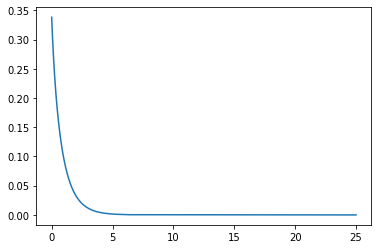

In [57]:
plt.plot(-np.log(quad_points), -np.array(np.real(results)))

In [ ]:
# N = 20,  0 - 10, dist = 0.5
0.043307825800406145

# N = 40,  0 - 10, dist = 0.5
0.0433498751667748

# N = 40,  0 - 10, dist = 0.5
0.04330939378247427

### Asymptotic series of large distance

In [4]:
coeff_list  = [-1/4, -1/4, -77/48, -25/16, -29837/2880, -6491/1152]
center_dist = np.linspace(2+0.5, 2+4, 15)

In [14]:
asy_casimir_energy_sphere_sphere = np.empty(N_Z, dtype='float64')

for i in range(N_Z):
    asy_casimir_energy = 0
    for j in range(len(coeff_list)):
        asy_casimir_energy += (1/center_dist[i]) * coeff_list[j] * (1/center_dist[i]**(j+2))
    asy_casimir_energy_sphere_sphere[i] = asy_casimir_energy/np.pi

In [15]:
asy_casimir_energy_sphere_sphere

array([-0.02097448, -0.01293535, -0.00849456, -0.00586688, -0.00422129,
       -0.00314093, -0.00240297, -0.00188172, -0.00150287, -0.00122068,
       -0.00100598, -0.00083957, -0.00070849, -0.00060375, -0.00051899])

In [6]:
casimir_energy_02 = [0.04252747355860449, 0.019009759072489033, 0.010656533220405127, 0.006742571449947622, 0.004608327155831826, 0.0033243468948433792,
                     0.0024950446492581382, 0.001930761169759118, 0.0015305418183628712, 0.0012375179883991733, 0.0010171903063033812, 0.0008479109277656718, 
                     0.000715368405580402, 0.0006098492481301255, 0.0005247329454344998]

casimir_energy_015 = [0.043307825800406145, 0.019256416561262993, 0.010769423052749767, 0.006803802858486751, 0.0046463126774433355, 0.003349537825626422,
                      0.0025125890997170133, 0.0019433886072260488, 0.0015400954595370371, 0.0012449470684107462, 0.0010231501919622393,0.0008526887192552412, 
                      0.0007192871007860663, 0.0006131518571655782, 0.0005275152934159557]

casimir_energy_01 = [0.04378745428729573, 0.019405016738122838, 0.0108371211616883, 0.006839815098643672, 0.004668668076015633, 0.0033642361277407182,
                     0.00252294856667685, 0.0019509389329729933, 0.001545811602948778, 0.001249392585883639, 0.0010266636493035802, 0.0008555719843788126,
                     0.0007216489407347166, 0.0006151174419268853, 0.0005291794672005568]

casimir_energy_005 = [0.04414292087373472, 0.019512906114365014, 0.010885881395436363, 0.006866214504299385, 0.004684510574395271, 0.0033746902360481004,
                      0.002530254775039599, 0.001956272874996258, 0.0015498433183263015, 0.0012525247040017652, 0.0010291599297457298, 0.000857591762488405,
                      0.0007233093491161761, 0.0006165021192206517, 0.0005303483008516043]

In [25]:
surf_dist

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  ])

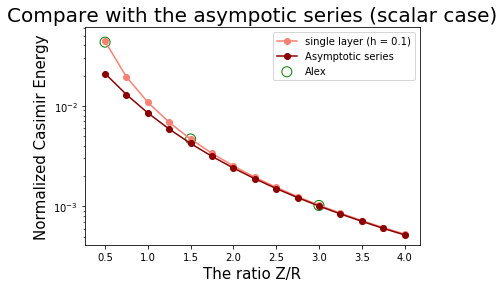

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

ref_x = [0.5,1.5,3]
ref_y = [0.0430362, 0.00467757, 0.00101948]
plt.semilogy(surf_dist, casimir_energy_01, color = 'salmon', linestyle = '-', marker = 'o')
plt.semilogy(surf_dist, -asy_casimir_energy_sphere_sphere, color = 'darkred', linestyle = '-', marker = 'o')
plt.scatter(ref_x, ref_y, s=100, facecolors='none', edgecolors='g')

plt.ylabel('Normalized Casimir Energy', fontsize = 15)
plt.legend(['single layer (h = 0.1)','Asymptotic series', 'Alex'], fontsize = 10)
plt.xlabel('The ratio Z/R', fontsize = 15)
plt.title('Compare with the asympotic series (scalar case)', fontsize = 20)
plt.savefig('Asymp Scalar.pdf', bbox_inches = 'tight')

In [23]:
rel_dist = []
for i in range(N_Z):
    rel_dist.append((-asy_casimir_energy_sphere_sphere[i] - casimir_energy_01[i])/-asy_casimir_energy_sphere_sphere[i])

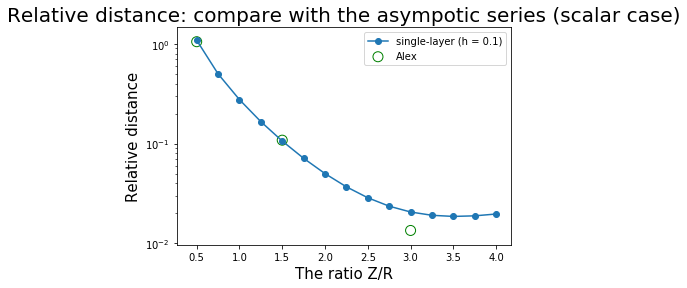

In [45]:
plt.semilogy(surf_dist, abs(np.array(rel_dist)),  linestyle = '-', marker = 'o')
plt.scatter(ref_x, [abs(-asy_casimir_energy_sphere_sphere[0] - 0.0430362)/-asy_casimir_energy_sphere_sphere[0], 
                   abs(-asy_casimir_energy_sphere_sphere[4] - 0.00467757)/-asy_casimir_energy_sphere_sphere[4],
                    abs(-asy_casimir_energy_sphere_sphere[10] - 0.00101948)/-asy_casimir_energy_sphere_sphere[10]], s=100, facecolors='none', edgecolors='g')
plt.xlabel('The ratio Z/R', fontsize = 15)
plt.ylabel('Relative distance', fontsize = 15)
plt.legend(['single-layer (h = 0.1)', 'Alex'], fontsize = 10)
plt.title('Relative distance: compare with the asympotic series (scalar case)', fontsize = 20)
plt.savefig('Asymp Scalar rel dist.pdf',  bbox_inches = 'tight')

In [2]:
Alex_ = [0.0430362, 0.00467757, 0.00101948]
h_02 = [0.04252747355860449, 0.004608327155831826, 0.0010171903063033812]
h_015 = [0.043307825800406145, 0.0046463126774433355, 0.0010231501919622393]
h_01 = [0.04378745428729573, 0.004668668076015633, 0.0010266636493035802]
h_005 = [0.04414292087373472, 0.004684510574395271, 0.0010291599297457298]

In [8]:
np.array([0.2773582018016356, 0.27512467115353667, 0.2721110889358884, 0.2672079962092814])/(2*np.pi)

array([0.04414293, 0.04378745, 0.04330782, 0.04252747])

In [ ]:
[abs(h_005[2]-Alex_[2])/Alex_[2], abs(h_01[2]-Alex_[2])/Alex_[2], abs(h_015[2]-Alex_[2])/Alex_[2],abs(h_02[2]-Alex_[2])/Alex_[2]]

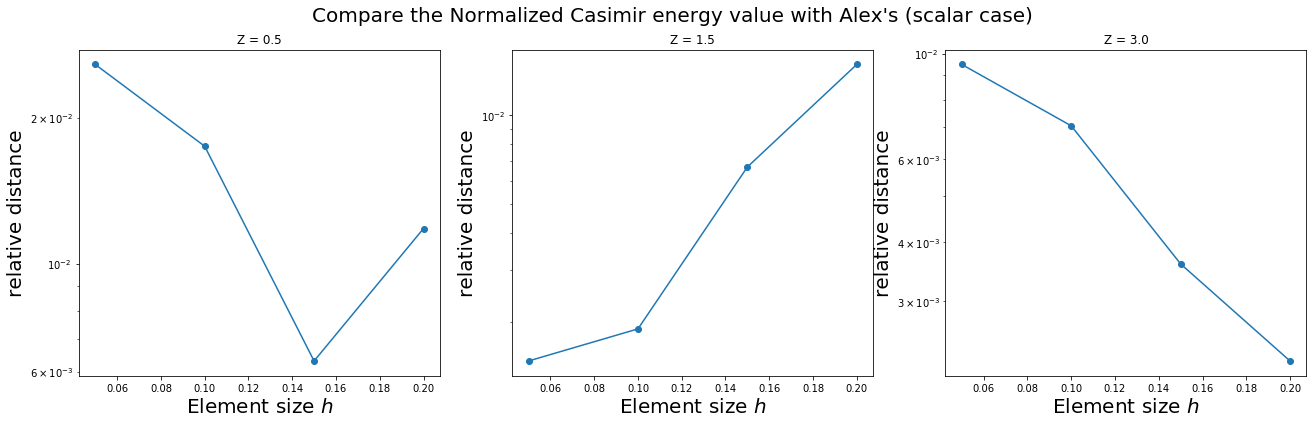

In [3]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(22, 6))
ax1.semilogy([0.05,0.1,0.15,0.2], [abs(h_005[0]-Alex_[0])/Alex_[0], abs(h_01[0]-Alex_[0])/Alex_[0], abs(h_015[0]-Alex_[0])/Alex_[0],abs(h_02[0]-Alex_[0])/Alex_[0]],'o-')
ax1.set_xlabel('Element size $h$', fontsize = 20)
ax1.set_ylabel('relative distance', fontsize = 20)
ax1.title.set_text('Z = 0.5')

ax2.semilogy([0.05,0.1,0.15,0.2], [abs(h_005[1]-Alex_[1])/Alex_[1], abs(h_01[1]-Alex_[1])/Alex_[1], abs(h_015[1]-Alex_[1])/Alex_[1],abs(h_02[1]-Alex_[1])/Alex_[1]],'o-')
ax2.set_xlabel('Element size $h$', fontsize = 20)
ax2.set_ylabel('relative distance', fontsize = 20)
ax2.title.set_text('Z = 1.5')

ax3.semilogy([0.05,0.1,0.15,0.2], [abs(h_005[2]-Alex_[2])/Alex_[2], abs(h_01[2]-Alex_[2])/Alex_[2], abs(h_015[2]-Alex_[2])/Alex_[2],abs(h_02[2]-Alex_[2])/Alex_[2]],'o-')
ax3.set_xlabel('Element size $h$', fontsize = 20)
ax3.set_ylabel('relative distance', fontsize = 20)
ax3.title.set_text('Z = 3.0')

fig.suptitle('Compare the Normalized Casimir energy value with Alex\'s (scalar case)', fontsize = 20)
fig.savefig('scalar: CasE.pdf')

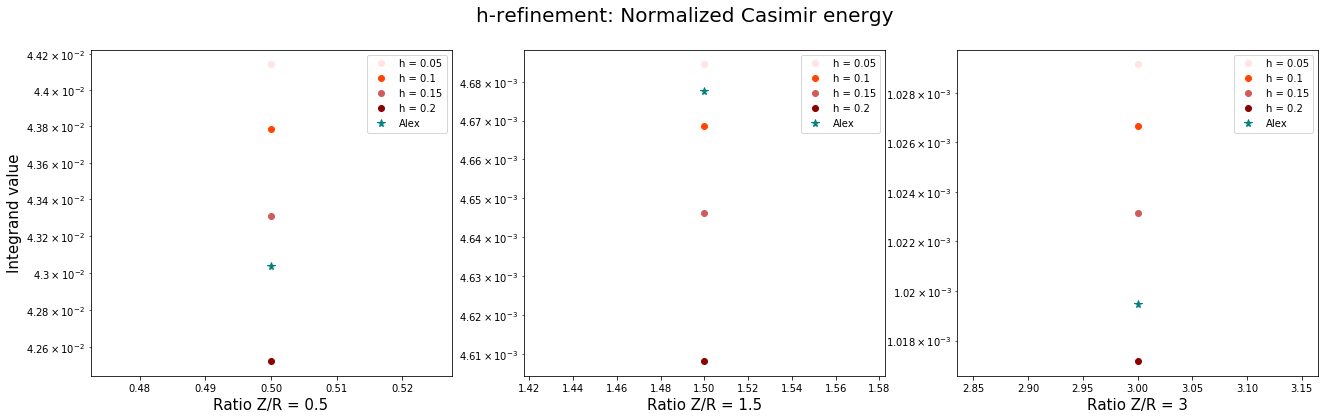

In [4]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(22, 6))
ax1.semilogy([0.5], [h_005[0]],'o', color = 'mistyrose')
ax1.semilogy([0.5], [h_01[0]], 'o', color = 'orangered')
ax1.semilogy([0.5], [h_015[0]],'o', color = 'indianred')
ax1.semilogy([0.5], [h_02[0]],'o', color = 'darkred')
ax1.semilogy([0.5], [Alex_[0]],'*', markersize = '8', color = 'teal')
ax1.legend(['h = 0.05','h = 0.1','h = 0.15','h = 0.2','Alex'])
ax1.set_xlabel('Ratio Z/R = 0.5', fontsize = 15)
ax1.set_ylabel('Integrand value', fontsize = 15)

ax2.semilogy([1.5], [h_005[1]],'o', color = 'mistyrose')
ax2.semilogy([1.5], [h_01[1]], 'o', color = 'orangered')
ax2.semilogy([1.5], [h_015[1]],'o', color = 'indianred')
ax2.semilogy([1.5], [h_02[1]],'o', color = 'darkred')
ax2.semilogy([1.5], [Alex_[1]],'*', markersize = '8', color = 'teal')
ax2.legend(['h = 0.05','h = 0.1','h = 0.15','h = 0.2','Alex'])
ax2.set_xlabel('Ratio Z/R = 1.5', fontsize = 15)
#ax2.ylabel('Integrand value', fontsize = 15)

ax3.semilogy([3], [h_005[2]],'o', color = 'mistyrose')
ax3.semilogy([3], [h_01[2]], 'o', color = 'orangered')
ax3.semilogy([3], [h_015[2]],'o', color = 'indianred')
ax3.semilogy([3], [h_02[2]],'o', color = 'darkred')
ax3.semilogy([3], [Alex_[2]],'*', markersize = '8', color = 'teal')
ax3.legend(['h = 0.05','h = 0.1','h = 0.15','h = 0.2','Alex'])
ax3.set_xlabel('Ratio Z/R = 3', fontsize = 15)
#ax3.ylabel('Integrand value', fontsize = 15)
fig.suptitle('h-refinement: Normalized Casimir energy', fontsize = 20)
fig.savefig('scalar: CasE.pdf')

In [9]:
alpha_02 = []
for i in range(len(casimir_energy_02)):
    alpha_02.append(abs(casimir_energy_02[i] - casimir_energy_005[i]))
    
alpha_015 = []
for i in range(len(casimir_energy_02)):
    alpha_015.append(abs(casimir_energy_015[i] - casimir_energy_005[i]))
    
alpha_01 = []
for i in range(len(casimir_energy_02)):
    alpha_01.append(abs(casimir_energy_01[i] - casimir_energy_005[i]))

Text(0, 0.5, 'absolute distance $E(h)$')

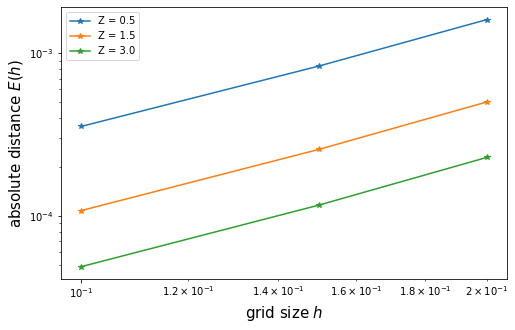

In [10]:
x_axis = [0.1, 0.15, 0.2]
plt.figure(figsize = [8,5])
plt.loglog(x_axis, [alpha_01[0], alpha_015[0], alpha_02[0]], '*-')
plt.loglog(x_axis, [alpha_01[1], alpha_015[1], alpha_02[1]], '*-')
plt.loglog(x_axis, [alpha_01[2],alpha_015[2],alpha_02[2]], '*-')
plt.legend(['Z = 0.5', 'Z = 1.5', 'Z = 3.0'], fontsize = 10)
plt.xlabel('grid size $h$', fontsize = 15)
plt.ylabel('absolute distance $E(h)$', fontsize = 15)

In [11]:
print(np.log(alpha_02[0]/alpha_01[0])/np.log(0.2/0.1),np.log(alpha_015[0]/alpha_01[0])/np.log(0.15/0.1))

2.184147841294569 2.106505114900219


In [ ]:
ref_x = [0.5,1.5,3]
ref_y1 = [0.0430362, 0.00467757, 0.00101948]
ref_y2 = [0.0440575, 0.00471758, 0.00106140]
plt.figure(figsize=[10,6])
plt.semilogy(surf_dist, casimir_energy_01, color = 'salmon', linestyle = '-', marker = '.')
#plt.semilogy(surf_dist, casimir_energy_01,'*-')
plt.scatter(ref_x, ref_y2, s=50, facecolors='none', edgecolors='b')
plt.scatter(ref_x, ref_y1, s=100, facecolors='none', edgecolors='g')
plt.legend(['h = 0.1', 'h = 0.05','Alex'])

plt.xlabel('The ratio Z/R', fontsize = 15)
plt.ylabel('The normalized Casimir energy', fontsize = 15)
plt.title('Normalized Casimir energy between two spheres', fontsize = 20)
plt.savefig('Scalar: Compare with Alex.pdf')

In [ ]:
h= 0.1

center1 = (2.5, 0, 0)
center2 = (-2.5, 0, 0)

sphere1 = bempp.api.shapes.sphere(h=h, origin=center1)
sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

In [ ]:
N = 10
lbound = 0
ubound = 10
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), N)
results = np.empty(N, dtype='float64')

In [ ]:
for index, point in enumerate(quad_points):
    
    wavenumber = -1j * np.log(point)
    
    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    p,l,u = scipy.linalg.lu(mat)
    logdet_mat = 0
    for i in range(u.shape[0]):
        logdet_mat += cmath.log(u[i,i])

    p2,l2,u2 = scipy.linalg.lu(mat2)
    logdet_mat2 = 0
    for i in range(u2.shape[0]):
        logdet_mat2 += cmath.log(u2[i,i])

    logdet = logdet_mat - logdet_mat2
    results[index] = np.real(logdet)
    print(logdet)

In [ ]:
casimir_energy = np.trapz(-results / quad_points, quad_points) / (2 * np.pi)
print(f"The normalized Casimir Energy is: {casimir_energy}")

In [ ]:
compensation1 = (results[-1] * np.log(quad_points[-1]))/(2*np.pi)
print(compensation1)

In [ ]:
casimir_energy + compensation1

In [ ]:
# h = 0.05 Z = 3 (R = 5):0.0010343333779947149 3.548589563727466e-06 0.0010378819675584423

# h = 0.05 Z = 0.5 (R = 2.5): 0.04409664162678309 2.701858012227347e-05 0.04412366020690536

# h = 0.05 Z = 1.5 (R = 3.5): 0.004686153917552493 8.460688310145012e-06 0.0046946146058626384

In [ ]:
plt.figure(figsize = [10,6])
plt.semilogy(-np.log(quad_points), -results, '*-')
plt.semilogy(-np.log(quad_points), np.exp(2*3*np.log(quad_points)), '*-')
plt.legend(['integrand value','$e^{-2Zk}$'],loc=1, prop={'size': 15})
plt.xlabel('ik', fontsize = 15)
plt.ylabel('Integrand value',fontsize = 15)
plt.savefig('Scalar: integrand value exp decay.pdf')

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('$\mathrm{i}$k')
ax1.set_ylabel('The value of the integrand')
ax2 = fig.add_subplot(122)
ax2.set_xlabel('exp(-k)')
ax1.semilogy(-np.log(quad_points), -results, '*-')
ax1.semilogy(-np.log(quad_points), np.exp(2*3*np.log(quad_points)), '*-')
ax2.plot(quad_points, -results, '*-')
ax2.set_ylabel('The value of the integrand')

In [ ]:
#h = 0.1 N = 10 (0.0005, 10) [0.04368308317546657, 0.01931289432739746, 0.010851995896095739, 0.0068698859786740975, 0.004701714825844722, 0.0033981652935409622,
#0.0025570617159480823, 0.001984851135802275, 0.0015792830659559708, 0.001282273891262514, 0.0010588641972866636, 0.0008870400209768652, 0.0007523580889270969
#0.0006450584086816148, 0.0005583543352397074]

#h = 0.05 N = 10 (0.0005, 10) [0.044057587968300865, 0.019419007732398477, 0.010900542085302476, 0.006896282876562902, 0.004717587477019146, 0.003408658186063775
#0.002564410855406871] not complpete

#h = 0.1 N = 20 (0.0005, 10) [0.04376056425924877, 0.019387112556034446, 0.010823838792645157, 0.006829394000217169, 0.004660187120532493, 0.0033571540883599975,
#0.0025169195982399505, 0.0019457285027467879, 0.001541253361784944, 0.001245364355886085, 0.0010230731910531702, 0.0008523480111274912, 0.0007187353628886178,
#0.0006124693871504389, 0.0005267605416446836]

#h = 0.05 N = 20 (0.0005, 10) [0.04411590724820102] not complete

#h = 0.1 N = 10 (0.0005, 20) [0.04355710341972167, 0.019304342297031235, 0.01085072670292802, 0.006868672372147117, 0.004700342078786005, 0.003397035464110822,
#0.0025556094189687073, 0.0019832340253504955, 0.0015778714560051314, 0.0012809697361217114, 0.0010574918358135267, 0.0008857127456911809, 0.0007510430536794689,
#0.0006435276034209508, 0.0005570871454980026]

#h = 0.05 N = 10 (0.0005, 20) [0.043992218663233, 0.01942247412150311] not complete

#h = 0.1 N = 20 (0.0005, 20) [0.04370172949888851, 0.019383111684513916, 0.010823236305849384, 0.006828817030836222, 0.004659535458380699, 0.003356617690931574,
#0.0025162305065443607, 0.001944961373867202, 0.0015405836080548802, 0.0012447455359834128, 0.0010224220973853717, 0.000851718308170755, 0.0007181114911078158
#0.0006117433408523157, 0.0005261593970734914]